In [1]:
import psycopg2 as pg2
import pandas as pd

con = pg2.connect(host='this_postgres', user='postgres', database='postgres')
con.autocommit = True
cur = con.cursor()

def select(sql):
    return pd.read_sql(sql,con)

In [2]:
sql = '''
drop table if exists sales_month;
create table sales_month as
select 

t.*,
s.invoice_cnt,
s.unitprice_sum,
1 as customer,
case when t.reg_month = t.month then 1 else 0 end as new,
case when s.invoice_cnt > 0 then 1 else 0 end as active,


extract(year from age(t.month, max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month))) * 12 +
extract(month from age(t.month, max(case when s.invoice_cnt > 0 then t.month else null end) 
over (partition by t.customerid order by t.month))) as last_order_cnt,


extract(year from age(t.month, t.reg_month)) * 12 +
extract(month from age(t.month, t.reg_month)) as lifetime






from user_month_1 t 

left join sales_month_agg s on t.customerid = s.customerid and
t.month = s.month

'''

In [3]:
cur.execute(sql)

In [4]:
sql = '''select * from sales_month t
where t.customerid = 12347.0
order by t.month'''

In [5]:
select(sql)

,customerid,reg_month,month,invoice_cnt,unitprice_sum,customer,new,active,last_order_cnt,lifetime
0,12347.0,2010-12-01,2010-12-01,1.0,89.59,1,1,1,0.0,0.0
1,12347.0,2010-12-01,2011-01-01,1.0,73.17,1,0,1,0.0,1.0
2,12347.0,2010-12-01,2011-02-01,NaN,NaN,1,0,0,1.0,2.0
3,12347.0,2010-12-01,2011-03-01,NaN,NaN,1,0,0,2.0,3.0
4,12347.0,2010-12-01,2011-04-01,1.0,62.29,1,0,1,0.0,4.0
5,12347.0,2010-12-01,2011-05-01,NaN,NaN,1,0,0,1.0,5.0
6,12347.0,2010-12-01,2011-06-01,1.0,53.62,1,0,1,0.0,6.0
7,12347.0,2010-12-01,2011-07-01,NaN,NaN,1,0,0,1.0,7.0
8,12347.0,2010-12-01,2011-08-01,1.0,68.24,1,0,1,0.0,8.0
9,12347.0,2010-12-01,2011-09-01,NaN,NaN,1,0,0,1.0,9.0


In [6]:
sql = '''select 

t.reg_month,
t.lifetime, sum(t.customer) as customer,
sum(t.new) as new,
sum(t.invoice_cnt) as invoice,
sum(t.unitprice_sum) as revenue,

sum(t.active) as active,

sum(t.active) * 1.0 / sum(t.customer) as active_pct,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt

from sales_month t 
group by t.reg_month,
t.lifetime
order by lifetime'''

In [7]:
df = select(sql)

In [8]:
df

,reg_month,lifetime,customer,new,invoice,revenue,active,active_pct,churn_2mnt_cnt
0,2011-08-01,0.0,167,167,203.0,14580.580,167,1.000000,0
1,2011-09-01,0.0,298,298,377.0,26948.221,298,1.000000,0
2,2011-01-01,0.0,421,421,547.0,38566.830,421,1.000000,0
3,2011-06-01,0.0,235,235,298.0,58776.260,235,1.000000,0
4,2011-10-01,0.0,352,352,455.0,47697.590,352,1.000000,0
...,...,...,...,...,...,...,...,...,...
86,2011-01-01,10.0,421,0,282.0,18784.570,155,0.368171,191
87,2010-12-01,10.0,948,0,762.0,47368.410,354,0.373418,438
88,2011-01-01,11.0,421,0,89.0,3942.030,63,0.149644,250
89,2010-12-01,11.0,948,0,1135.0,65024.220,474,0.500000,372


In [9]:
df.pivot_table(index='reg_month',columns='lifetime',values='active_pct',aggfunc='max')

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
reg_month,,,,,,,,,,,,,
2010-12-01,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02-01,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03-01,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04-01,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
import seaborn as sns

(13.0, 0.0)

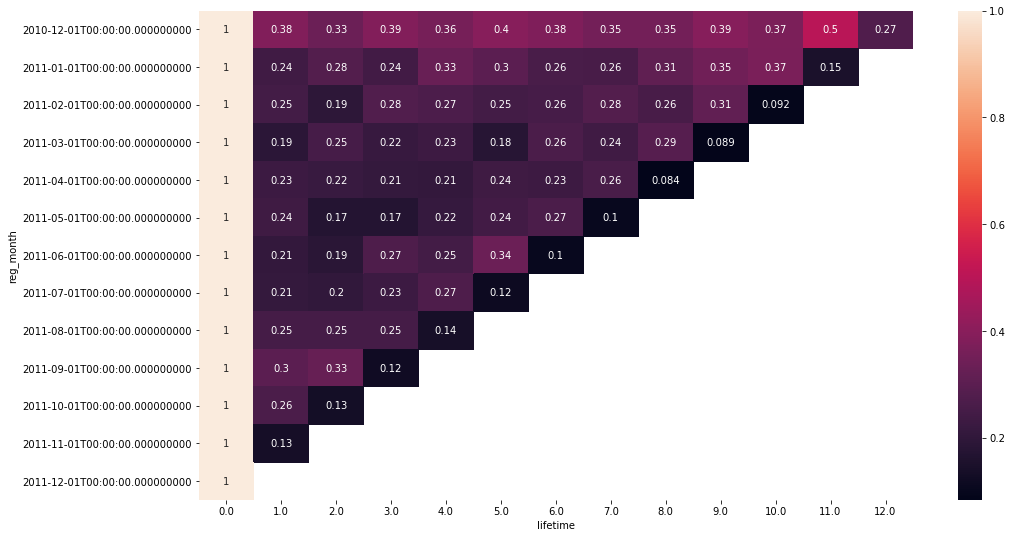

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(df.pivot_table(index='reg_month',columns='lifetime',values='active_pct'),annot=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

In [12]:
df.pivot_table(index='reg_month',values='active_pct',aggfunc='mean')

,active_pct
reg_month,
2010-12-01,0.422347
2011-01-01,0.340459
2011-02-01,0.312201
2011-03-01,0.295227
2011-04-01,0.297659
2011-05-01,0.301075
2011-06-01,0.336170
2011-07-01,0.338569
2011-08-01,0.378443


In [13]:
df.pivot_table(index='lifetime',values='active_pct',aggfunc='mean')

,active_pct
lifetime,
0.0,1.000000
1.0,0.240856
2.0,0.232326
3.0,0.238429
4.0,0.251881
5.0,0.256637
6.0,0.251151
7.0,0.249332
8.0,0.259147


In [14]:
sql = '''select 

t.lifetime, 

sum(t.invoice_cnt) as invoice,
sum(t.unitprice_sum) as revenue,

sum(t.active) as active,

sum(t.active) * 1.0 / sum(t.customer) as active_pct,

sum(case when t.last_order_cnt >= 2 then 1 else 0 end) as churn_2mnt_cnt

from sales_month t 
group by t.lifetime
order by t.lifetime'''

In [15]:
df = select(sql)

In [16]:
df

,lifetime,invoice,revenue,active,active_pct,churn_2mnt_cnt
0,0.0,6067.0,446307.073,4372,1.000000,0
1,1.0,1828.0,101385.920,1131,0.261141,0
2,2.0,1607.0,96896.920,1003,0.250125,2393
3,3.0,1622.0,115035.890,968,0.264625,2164
4,4.0,1492.0,80266.650,938,0.279167,1916
5,5.0,1584.0,106661.400,914,0.286251,1789
6,6.0,1434.0,72238.650,850,0.283145,1682
7,7.0,1345.0,73521.930,763,0.275750,1566
8,8.0,1240.0,73813.561,717,0.288183,1401
9,9.0,1268.0,84735.970,678,0.309730,1164


In [17]:
sql = '''select t.month, sum(t.new) from sales_month t
group by t.month
order by t.month'''

In [18]:
select(sql)

,month,sum
0,2010-12-01,948
1,2011-01-01,421
2,2011-02-01,380
3,2011-03-01,440
4,2011-04-01,299
5,2011-05-01,279
6,2011-06-01,235
7,2011-07-01,191
8,2011-08-01,167
9,2011-09-01,298
